# DCASE 2025 Task 1 
Partha's model on mel-specs dataset

# Importing libraries

In [1]:
print("Notebook begins ...")
import random
import numpy as np
import pandas as pd
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics import Accuracy
from collections import defaultdict
import torchinfo
import os
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchmetrics
from torchinfo import summary

print("Environment setup complete")

Notebook begins ...


2025-06-15 22:13:19.486746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750025599.672516      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750025599.727440      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Environment setup complete


# Defining Parameters

In [2]:
# Configuration dictionary
params = {
    # Dataset paths
    'train_file': "/kaggle/input/dcase-2025-task1-melspecs/dataset/train.npz",
    # We use IR augmented samples for real devices (a, b, c) but set aug_train_file to None for simulated devices (s1, s2, s3).
    'aug_train_file': None, #"/kaggle/input/dcase-2025-task1-melspecs-aug/dataset/train.npz", # or set to None
    'test_file': "/kaggle/input/dcase-2025-task1-melspecs/dataset/test.npz",
    # Audio processing parameters
    'nb_mels': 256,
    'mel_seq_len': 64,  # Will be set dynamically
    # Model parameters
    'net_type': 'cnn',
    'loadmodel' : None,
    # Training parameters
    'nb_epochs': 500,
    'patience' : 150,
    'batch_size': 8,
    'nb_workers': 4,
    'shuffle': True,
    # Optimizer parameters
    'learning_rate': 1e-3,
    # Checkpoint and logging
    'checkpoints_dir': '/kaggle/working/',
    'log_dir': '/kaggle-working/',
    # Dataset params
    'dataset_version' : 2,
    # freq_mix_style
    'mix_style_p': 0.4,
    'mix_style_alpha': 0.3,
    'freqmixstyle_p' : 0.4,
    'freqmixstyle_alpha' : 0.3,
    'device_mask_p': 0,
    'time_mask_param' : 8,
    'freq_mask_param' : 48,
    # T and Alpha havedifferent values for each submission.
    # for system 1 : T=2 , Alpha=0.4
    # for system 2 : T=4 , Alpha=0.7
    # for system 3 : T=6 , Alpha=0.95
    'T' : 4.0,
    'Alpha' : 0.7,
    # set rec_device to train a device specific model
    'rec_device' : 's1'
}
print("\n\n")
print(params)
print("\n\n")

rec_device = params['rec_device']

device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Device configuration
print(f"Device: {device}")

phase = 'debug'  # Phase flag for debugging. Set to 'debug' or 'full'
phase = 'full' if device == 'cuda:0' else phase
if phase == "debug" : 
    params['nb_epochs'] = 5
    params['batch_size'] = 2
print(f"Phase: {phase}")




{'train_file': '/kaggle/input/dcase-2025-task1-melspecs/dataset/train.npz', 'aug_train_file': None, 'test_file': '/kaggle/input/dcase-2025-task1-melspecs/dataset/test.npz', 'nb_mels': 256, 'mel_seq_len': 64, 'net_type': 'cnn', 'loadmodel': None, 'nb_epochs': 500, 'patience': 150, 'batch_size': 8, 'nb_workers': 4, 'shuffle': True, 'learning_rate': 0.001, 'checkpoints_dir': '/kaggle/working/', 'log_dir': '/kaggle-working/', 'dataset_version': 2, 'mix_style_p': 0.4, 'mix_style_alpha': 0.3, 'freqmixstyle_p': 0.4, 'freqmixstyle_alpha': 0.3, 'device_mask_p': 0, 'time_mask_param': 8, 'freq_mask_param': 48, 'T': 2.0, 'Alpha': 0.4, 'rec_device': 's1'}



Device: cuda:0
Phase: full


# Utility Functions

In [3]:
def get_class_name(klass='unk',getall=False):
    # Class mappings
    classes_names = {'airport': 0, 'shopping_mall': 1, 'metro_station': 2, 'street_pedestrian': 3,'public_square': 4, 'street_traffic': 5, 'tram': 6, 'bus': 7, 'metro': 8, 'park': 9}
    class_indx = {v: k for k, v in classes_names.items()}
    if getall :
        return classes_names
    classes_names = classes_names | class_indx
    return classes_names.get(klass)

def get_device_name(dev='unk',getall=False):
    # Class mappings
    devices_names = {'a' : 0,'b' : 1,'c' : 2,'s1': 3,'s2': 4,'s3': 5,'unk': 6}
    devices_indx = {0 : 'a', 1 : 'b', 2 : 'c', 3 : 's1', 4 : 's2', 5 : 's3', 6 : 'unk'}
    if getall :
        return devices_names
    devices_names = devices_names | devices_indx
    return devices_names.get(dev) if devices_names.get(dev) != None else 6

from torch.distributions.beta import Beta

# MixStyle (provided code, included for completeness)
def mixstyle(x, p=0.4, alpha=0.3, eps=1e-6):
    if np.random.rand() > p:
        return x
    batch_size = x.size(0)

    # frequency-wise statistics
    f_mu = x.mean(dim=[1, 3], keepdim=True)
    f_var = x.var(dim=[1, 3], keepdim=True)

    f_sig = (f_var + eps).sqrt()  # compute instance standard deviation
    f_mu, f_sig = f_mu.detach(), f_sig.detach()  # block gradients
    x_normed = (x - f_mu) / f_sig  # normalize input
    lmda = Beta(alpha, alpha).sample((batch_size, 1, 1, 1)).to(x.device)  # sample instance-wise convex weights
    perm = torch.randperm(batch_size).to(x.device)  # generate shuffling indices
    f_mu_perm, f_sig_perm = f_mu[perm], f_sig[perm]  # shuffling
    mu_mix = f_mu * lmda + f_mu_perm * (1 - lmda)  # generate mixed mean
    sig_mix = f_sig * lmda + f_sig_perm * (1 - lmda)  # generate mixed standard deviation
    x = x_normed * sig_mix + mu_mix  # denormalize input using the mixed frequency statistics
    return x

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Analyze data shapes
def analyze_data_shapes(loader, dataset_name):
    for batch in loader:
        waveforms, devices, labels = batch
        params['mel_seq_len'] = waveforms.shape[-1]
        print(f"{dataset_name} Data Shapes:")
        print(f"  Waveforms: {waveforms.shape} (batch_size, mel_bins, time_steps)\n")
        break

# Visualize a sample
def plot_mel_spectrogram(mel_spec, label, dev=None):
    label = get_class_name(label.item())# list(classes.keys())[class_idx]
    plt.figure(figsize=(10, 5))
    plt.imshow(mel_spec.squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Mel Spectrogram - Class: {label}" +  (f" - Device: {dev}" if dev!=None else ""))
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(label="Log2 Magnitude")
    plt.tight_layout()
    plt.show()
    print("\n")

def create_dataloader(dataset,batchsize=64,shuffle=True,phase="debug"):
    if phase == 'debug':
        dataloader = DataLoader(dataset=Subset(dataset, range(16)),batch_size=2,num_workers=4,shuffle=shuffle,drop_last=True)
    else:
        dataloader = DataLoader(dataset=dataset,batch_size=batchsize,num_workers=4,shuffle=shuffle,drop_last=True)
    
    return dataloader



# Defining data generator class

In [4]:
import torch
import torchaudio
import numpy as np
import random
from torch.utils.data import Dataset

class MelSpecsDataset(Dataset):
    def __init__(self, npz_path, augs=['time_roll', 'rnd_gain', 'rnd_noise', 'time_mask', 'freq_mask'], 
                 rec_device='gen', all_mels=False, dataset_version=3, include_augmented=False):
        self.augs = augs if augs is not None else []  # Ensure augs is an empty list if None
        self.path = npz_path
        self.dataset_version = dataset_version
        self.rec_device = rec_device
        self.include_augmented = include_augmented  # New parameter to control augmented sample inclusion
        
        data = np.load(self.path)  # Load the .npz file

        if dataset_version == 3:
            self.data = data['wave']  # for version 3
        else:
            self.data = data['mel']  # for version 1 and 2 of the dataset
            
        self.names = data['name']
        self.devs = self.encode2int_dev(data['device'])  # Loaded as a numpy array
        self.labels = self.encode2int_class(data['label'])  # Loaded as a numpy array

        # Apply filtering based on rec_device and include_augmented
        mask = np.ones(len(self.names), dtype=bool)  # Initialize mask as all True
        if rec_device != 'gen':
            mask = (data['device'] == rec_device).astype(bool)  # Base mask for rec_device
            if self.include_augmented:
                # Include augmented samples where the prefix before _AUG matches rec_device
                aug_mask = np.array([self._check_augmented_sample(name, rec_device) for name in self.names])
                mask = mask | aug_mask  # Combine with OR to include augmented samples
        else:
            if self.include_augmented:
                # Include all samples if rec_device is 'gen' and include_augmented is True
                mask = np.ones(len(self.names), dtype=bool)
            else:
                # Exclude augmented samples by checking for '_AUG' in the name
                mask = np.array([('_AUG' not in name) for name in self.names])

        self.data = self.data[mask]
        self.names = self.names[mask]
        self.devs = self.devs[mask]
        self.labels = self.labels[mask]

        if dataset_version == 3:
            self.melspecs_params = {
                'target_fs': 32000,
                'fft_size': 4096,
                'hop_length': 502,
                'nb_mels': 256
            }
            self.roll_in_samples = int(0.125 * self.melspecs_params['target_fs'])  # 125 ms rolling
            self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
                sample_rate=self.melspecs_params['target_fs'],
                n_fft=self.melspecs_params['fft_size'],
                hop_length=self.melspecs_params['hop_length'],
                n_mels=self.melspecs_params['nb_mels'],
                power=2.0
            )

        # Data augmentation transforms (for training only)
        self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=params['time_mask_param'])
        self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=params['freq_mask_param'])
                 
    def __getitem__(self, item):
        log_mel_tensor = torch.tensor(self.data[item], dtype=torch.float32)
        dev = torch.tensor(self.devs[item])
        label = torch.tensor(self.labels[item])
        name = self.names[item]  # Include the sample name in the output
        
        if self.augs:  # Apply spectral augmentations only if self.augs is not empty
            if 'rnd_gain' in self.augs:
                # Apply random gain
                if random.random() < 0.5:
                    gain = random.uniform(0.7, 1.3)
                    log_mel_tensor = log_mel_tensor * gain
            if 'rnd_noise' in self.augs:
                # Apply additive Gaussian noise
                if random.random() < 0.5:
                    noise = torch.randn_like(log_mel_tensor) * 0.005
                    log_mel_tensor = log_mel_tensor + noise
            if 'time_mask' in self.augs:
                log_mel_tensor = self.time_masking(log_mel_tensor)
            if 'freq_mask' in self.augs:
                log_mel_tensor = self.freq_masking(log_mel_tensor)
            
        return log_mel_tensor.unsqueeze(0), dev, label  
    def __len__(self):
        return len(self.devs)

    def get_statistics(self):
        unique_classes = np.array(list(get_class_name(getall=True).values()))
        unique_devices = np.array(list(get_device_name(getall=True).values()))
        hist, xedges, yedges = np.histogram2d(
            self.labels, self.devs,
            bins=[len(unique_classes), len(unique_devices)],
            range=[[min(unique_classes), max(unique_classes) + 1],
                   [min(unique_devices), max(unique_devices) + 1]]
        )
        return hist.astype(int)

    @staticmethod
    def encode2int_class(values):
        return np.array([get_class_name(klass=v) for v in values])

    @staticmethod
    def encode2int_dev(values):
        return np.array([get_device_name(dev=v) for v in values])

    def _check_augmented_sample(self, name, rec_device):
        """Check if the sample is augmented and its prefix matches rec_device."""
        if '_AUG' in name:
            prefix = name.split('_AUG')[0].split('-')[-1]  # Get the part after the last '-' before '_AUG'
            return prefix == rec_device
        return False  # Non-augmented samples are handled by the main rec_device filter

print("Data Generator declared")

Data Generator declared


# Declaration of Train/Test Datasets

In [5]:
# del train_dataset, aug_train_dataset, test_dataset
# Initialize datasets
train_dataset = MelSpecsDataset(npz_path=params['train_file'],dataset_version=params['dataset_version'],rec_device=rec_device)

aug_train_dataset = None
if params['aug_train_file'] != None:
    aug_train_dataset = MelSpecsDataset(npz_path=params['aug_train_file'],dataset_version=params['dataset_version'],rec_device=rec_device, include_augmented=True)
    
test_dataset = MelSpecsDataset(npz_path=params['test_file'],dataset_version=params['dataset_version'], augs=None, rec_device=rec_device)
print("Datasets defined")

Datasets defined


## Analyze datasets

In [6]:
print(f"Number of samples - Training: {len(train_dataset)}, Testing: {len(test_dataset)}, Aug: {len(aug_train_dataset) if aug_train_dataset != None else 'None'}\n")

print("Joint count matrix for Train dataset")
df = pd.DataFrame(train_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
print(df,end="\n\n\n")

print("Joint count matrix for Test dataset")
df = pd.DataFrame(test_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
print(df,end="\n\n\n")

if aug_train_dataset != None:
    print("Joint count matrix for Augmented Train dataset")
    df = pd.DataFrame(aug_train_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
    print(df,end="\n\n\n")
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, aug_train_dataset])
    del aug_train_dataset

Number of samples - Training: 1840, Testing: 3300, Aug: None

Joint count matrix for Train dataset
                   a  b  c   s1  s2  s3  unk
airport            0  0  0  170   0   0    0
shopping_mall      0  0  0  180   0   0    0
metro_station      0  0  0  190   0   0    0
street_pedestrian  0  0  0  190   0   0    0
public_square      0  0  0  180   0   0    0
street_traffic     0  0  0  170   0   0    0
tram               0  0  0  200   0   0    0
bus                0  0  0  170   0   0    0
metro              0  0  0  200   0   0    0
park               0  0  0  190   0   0    0


Joint count matrix for Test dataset
                   a  b  c   s1  s2  s3  unk
airport            0  0  0  330   0   0    0
shopping_mall      0  0  0  330   0   0    0
metro_station      0  0  0  330   0   0    0
street_pedestrian  0  0  0  330   0   0    0
public_square      0  0  0  330   0   0    0
street_traffic     0  0  0  330   0   0    0
tram               0  0  0  330   0   0    0
bus     

# Declaration of Train/Test data loaders

In [7]:
# Create data loaders based on phase
train_loader = create_dataloader(dataset=train_dataset, batchsize=params['batch_size'], shuffle=params['shuffle'],phase=phase)
test_loader = create_dataloader(dataset=test_dataset, batchsize=1024, shuffle=False,phase=phase)    
num_training_batchs = len(train_loader)
num_testing_batchs = len(test_loader)
print(f"Number of batches - Training: {num_training_batchs}, Testing: {num_testing_batchs}")

Number of batches - Training: 230, Testing: 3


## Analyze data loaders

Training Data Shapes:
  Waveforms: torch.Size([8, 1, 256, 64]) (batch_size, mel_bins, time_steps)



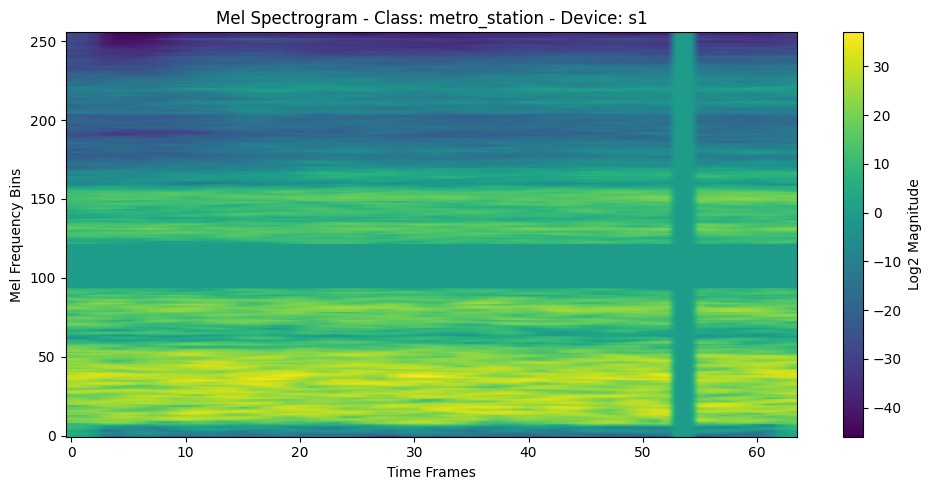



Testing Data Shapes:
  Waveforms: torch.Size([1024, 1, 256, 64]) (batch_size, mel_bins, time_steps)



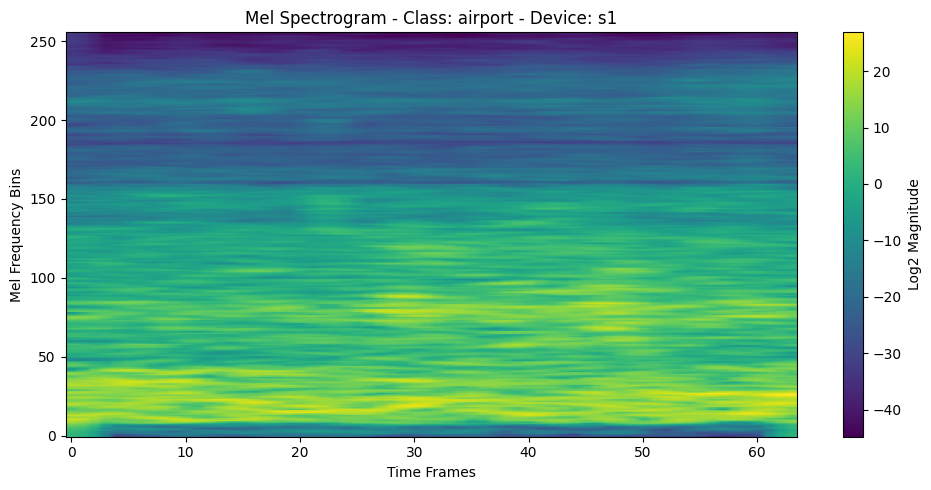

In [8]:
analyze_data_shapes(train_loader, "Training")
for waveforms, devices, labels in train_loader:
    i = random.randint(0,params['batch_size']-1)
    plot_mel_spectrogram(waveforms[i], labels[i], get_device_name(dev=int(devices[i])))
    break

analyze_data_shapes(test_loader, "Testing")
for waveforms, devices, labels in test_loader:
    i = random.randint(0,params['batch_size']-1)
    plot_mel_spectrogram(waveforms[i], labels[i], get_device_name(dev=int(devices[i])))
    break

### DEFINE ALL TEACHER MODELS

In [9]:
list_of_all_models = []#list for save all models
def evaluate_test_dataset(model, loader, loss_fn, metric):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    device_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    with torch.no_grad():
        for batch in loader:
            waveforms, devices, labels = [x.to(device) for x in batch]
            outputs = model(waveforms)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_correct += metric(preds, labels).item() * labels.size(0)
            total_samples += labels.size(0)

            for dev, pred, lbl in zip(devices, preds, labels):
                dev_id = dev.item()
                device_stats[dev_id]['correct'] += (pred == lbl).item()
                device_stats[dev_id]['total'] += 1

    avg_loss = total_loss / len(loader)
    avg_acc = (total_correct / total_samples)
    
    print(f"  Validation - Loss: {avg_loss:.4f}, Accuracy: {avg_acc*100:3.1f}%")
    # print("      Validation Device Accuracies:")
    device_names = [get_device_name(dev=dev_id) for dev_id, _ in device_stats.items()]
    stats_list = [(s['correct'], s['total']) for s in device_stats.values()]
    print("        " + "\t".join(f"{name:5}" for name in device_names))
    print("        " + "\t".join(f"{c/t*100:3.1f}%" for c, t in stats_list))
    
    return avg_loss, avg_acc, device_stats

In [10]:
def ReParametrize(module):
    """
    Recursively replaces all RepConv2d layers in a module with their reparametrized version.
    """
    for name, child in list(module.named_children()):
        if isinstance(child, RepConv2d):
            # print(f"Reparametrizing {name}")
            new_module = child.get_reparametrized_layer()
            setattr(module, name, new_module)
        else:
            ReParametrize(child)


class RepConv2d(nn.Module):
    def __init__(self, input_channel, output_channel, stride=(1, 1), groups=1):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.stride = stride

        # Initial convolutions
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 3),
                               stride=stride, padding=(1, 1), bias=False,groups=groups)
        self.bn1 = nn.BatchNorm2d(output_channel)

        self.conv2 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 3),
                               stride=stride, padding=(0, 1), bias=False,groups=groups)
        self.bn2 = nn.BatchNorm2d(output_channel)

        self.conv3 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 1),
                               stride=stride, padding=(1, 0), bias=False,groups=groups)
        self.bn3 = nn.BatchNorm2d(output_channel)

        self.conv4 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 1),
                               stride=stride, padding=(0, 0), bias=False,groups=groups)
        self.bn4 = nn.BatchNorm2d(output_channel)

    def forward(self, x):
        x1 = self.conv1(x)
        # x1 = self.bn1(x1)
        x2 = self.conv2(x)
        # x2 = self.bn2(x2)
        x3 = self.conv3(x)
        # x3 = self.bn3(x3)
        x4 = self.conv4(x)
        # x4 = self.bn4(x4)
        return x1 + x2 + x3 + x4

    def merge_batchnorms(self):
        bn_list = [self.bn1, self.bn2, self.bn3, self.bn4]
        num_features = bn_list[0].num_features
        merged_bn = nn.BatchNorm2d(num_features).to(bn_list[0].weight.device)

        # Merge running stats
        merged_bn.running_mean = torch.mean(torch.stack([bn.running_mean for bn in bn_list]), dim=0)
        merged_bn.running_var = torch.mean(torch.stack([bn.running_var for bn in bn_list]), dim=0)

        if bn_list[0].affine:
            merged_bn.weight.data = torch.mean(torch.stack([bn.weight.data for bn in bn_list]), dim=0)
            merged_bn.bias.data = torch.mean(torch.stack([bn.bias.data for bn in bn_list]), dim=0)

        return merged_bn

    def merge_convs(self):
        conv2ds_list = [self.conv1, self.conv2, self.conv3, self.conv4]
        main_shape = conv2ds_list[0].weight.data.shape
        device = conv2ds_list[0].weight.device  # Get device from one of the convs

        # Initialize zero tensors on the correct device
        conv1 = conv2ds_list[0].weight.data
        conv2 = torch.zeros(main_shape, device=device)
        conv3 = torch.zeros(main_shape, device=device)
        conv4 = torch.zeros(main_shape, device=device)

        # Fill the corresponding parts
        conv2[:, :, 1, :] = conv2ds_list[1].weight.data.squeeze(2)
        conv3[:, :, :, 1] = conv2ds_list[2].weight.data.squeeze(3)
        conv4[:, :, 1, 1] = conv2ds_list[3].weight.data.squeeze(3).squeeze(2)

        # Create new Conv2d layer on same device
        conv2d = nn.Conv2d(
            in_channels=self.conv1.in_channels,
            out_channels=self.conv1.out_channels,
            kernel_size=self.conv1.kernel_size,
            stride=self.conv1.stride,
            padding=self.conv1.padding,
            bias=False,
            groups=self.conv1.groups
        ).to(device)

        with torch.no_grad():
            conv2d.weight.copy_((conv1 + conv2 + conv3 + conv4))

        return conv2d

    def get_reparametrized_layer(self):
        conv2d = self.merge_convs()
        bn = self.merge_batchnorms()
        # return nn.Sequential(conv2d, bn)
        return nn.Sequential(conv2d)

class LearnablePooling(nn.Module):
    def __init__(self, in_channels, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_channels // 2
        self.bn_input = nn.BatchNorm2d(in_channels)
        self.attn_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn_attn = nn.BatchNorm2d(hidden_dim)
        self.attn_score = nn.Conv2d(hidden_dim, in_channels, kernel_size=1, bias=False)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  

    def forward(self, x):
        x_norm = self.bn_input(x)
        
        attn = self.attn_conv(x_norm)
        attn_norm = self.bn_attn(attn)
        attn_act = self.act(attn_norm)
        scores = self.attn_score(attn_act)
        b, c, h, w = x.size()
        weights = F.softmax(scores.view(b, c, -1), dim=-1)
        weights = weights.view(b, c, h, w)
        attn_pooled = (x * weights).view(b, c, -1).sum(dim=-1)  
        
        gap = self.global_avg_pool(x).view(b, c)  
        
        out = torch.cat([attn_pooled, gap], dim=1) 
        return out


class ResidualNormalization(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.lambda_param = nn.Parameter(torch.ones(1))
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=True)
    
    def forward(self, x):
        return self.lambda_param * x + self.instance_norm(x) 

class DSFlexiNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super().__init__()
        self.stride = stride
        self.use_skip = True

        mid_channels = out_channels 
        
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.scaleinput = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.act1 = nn.LeakyReLU()
        self.do1 = nn.Dropout2d(0)
        
        self.norm2 = nn.BatchNorm2d(mid_channels)
        self.conv2 = RepConv2d(input_channel=mid_channels, output_channel=mid_channels, stride=stride, groups=mid_channels)
        self.act2 = nn.LeakyReLU()
        # self.do2 = nn.Dropout2d(0)

        self.norm3 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels , out_channels , kernel_size = 1 , bias = False , groups = mid_channels )
        self.do3 = nn.Dropout2d(0.15)     
        
        self.norm4 = ResidualNormalization(out_channels)       
        
    def forward(self, x):   
        
        out = self.norm1(x)
        scaledInput = self.scaleinput(x) if self.use_skip else None
        out = self.conv1(out)
        out = self.act1(out)
        out = self.do1(out)

        out = self.norm2(out)
        out = self.conv2(out)
        out = self.act2(out)
        # out = self.do2(out)

        out = self.norm3(out)
        out = self.conv3(out)
        out = self.act2(out)
        out = self.do3(out)
        
        if self.use_skip:
            out = out + scaledInput
        
        out = self.norm4(out)
        
        return out

class DSFlexiNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Initial convolutions
        self.initial_conv1 = RepConv2d(input_channel=1, output_channel=16, stride=(2,2))
        self.rn1 = nn.BatchNorm2d(1)
        self.act1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.1)
        
        self.initial_conv2 = RepConv2d(input_channel=16, output_channel=32, stride=(2,2))
        self.rn2 = nn.BatchNorm2d(16)
        self.act2 = nn.ReLU()
        
        # DS-FlexiNet blocks
        self.stage1 = nn.Sequential(
            DSFlexiNetBlock(32 , 32 ,  stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(32 , 32 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock( 32 , 32 , stride=(1,1), expansion_factor=6)
        )

        self.stage2 = nn.Sequential(
            DSFlexiNetBlock(64 , 64 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(64 , 64 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(64 , 64 , stride=(1,1), expansion_factor=6),
        )
        
        self.stage3 = nn.Sequential(
            DSFlexiNetBlock( 96 , 128 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock( 128 , 128 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock( 128 , 128 , stride=(1,1), expansion_factor=6),
        )
        
        # Global average pooling and fully connected layer
        self.avgpool_3 = LearnablePooling(128)
        self.avgpool_2 = LearnablePooling(64)
        self.avgpool_1 = LearnablePooling(32)
        self.bn_final = nn.BatchNorm1d((128+32+64) * 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(((128+32+64) * 2 ), num_classes)
        # self.act3 = nn.ReLU()
        # self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x, recording_device=None):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.rn1(x)
        x = self.initial_conv1(x)
        x = self.act1(x)
        x = self.rn2(x)
        x = self.initial_conv2(x)
        x = self.act2(x)
        x = self.dropout_1(x)
        
        x_1_o1 = self.stage1(x)
        x_1 = torch.cat([x , x_1_o1 ] , dim = 1)
        x_2_o2 = self.stage2(x_1) 
        x_2 = torch.cat([x , x_2_o2] , dim = 1)
        x_3_o3 = self.stage3(x_2)
        x_3 = torch.cat([x , x_2] , dim = 1)
        
        x_3_o3= self.avgpool_3(x_3_o3)
        x_2_o2= self.avgpool_2(x_2_o2)
        x_1_o1= self.avgpool_1(x_1_o1)
        x = torch.cat([x_3_o3 , x_2_o2 , x_1_o1] , dim = 1)                     
        x = self.dropout(x)
        x = self.bn_final(x)
        x = self.fc1(x)
        # x = self.act3(x)
        # x = self.fc2(x)
        return x

print("Model architecture defined")

# Initialize model and move to device
model_DSF_AMIR = DSFlexiNet().to(device)
checkpoint = torch.load("/kaggle/input/dcase2025-task1-models/pytorch/all-use-models/1/DSF_AMIR.pth")
model_DSF_AMIR.load_state_dict(checkpoint['model_state_dict'])
model_DSF_AMIR.eval()
loss_fn = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
test_loss, test_acc, test_device_stats = evaluate_test_dataset(
    model_DSF_AMIR, test_loader, loss_fn, metric)
print("final : ",test_acc*100)
list_of_all_models.append(model_DSF_AMIR)

Model architecture defined
  Validation - Loss: 1.3720, Accuracy: 51.9%
        s1   
        51.9%
final :  51.888020833333336


In [11]:
def get_reparametrized_layer(self):
    conv2d = self.merge_convs()
    bn = self.merge_batchnorms()
    # return nn.Sequential(conv2d, bn)
    return nn.Sequential(conv2d)
class LearnablePooling(nn.Module):
    def __init__(self, in_channels, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_channels // 2
        self.bn_input = nn.BatchNorm2d(in_channels)
        self.attn_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn_attn = nn.BatchNorm2d(hidden_dim)
        self.attn_score = nn.Conv2d(hidden_dim, in_channels, kernel_size=1, bias=False)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  

    def forward(self, x):
        x_norm = self.bn_input(x)
        
        attn = self.attn_conv(x_norm)
        attn_norm = self.bn_attn(attn)
        attn_act = self.act(attn_norm)
        scores = self.attn_score(attn_act)
        b, c, h, w = x.size()
        weights = F.softmax(scores.view(b, c, -1), dim=-1)
        weights = weights.view(b, c, h, w)
        attn_pooled = (x * weights).view(b, c, -1).sum(dim=-1)  
        
        gap = self.global_avg_pool(x).view(b, c)  
        
        out = torch.cat([attn_pooled, gap], dim=1) 
        return out


class ResidualNormalization(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.lambda_param = nn.Parameter(torch.ones(1))
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=True)
    
    def forward(self, x):
        return self.lambda_param * x + self.instance_norm(x) 

class DSFlexiNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super().__init__()
        self.stride = stride
        self.use_skip = (in_channels <= out_channels)

        mid_channels = in_channels * expansion_factor
        
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.scaleinput = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.act1 = nn.LeakyReLU()
        # self.do1 = nn.Dropout2d(0)
        
        self.norm2 = nn.BatchNorm2d(mid_channels)
        # self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, 
        #                       padding=1, groups=mid_channels, bias=False)
        self.conv2 = RepConv2d(input_channel=mid_channels, output_channel=mid_channels, stride=stride, groups=mid_channels)
        self.act2 = nn.LeakyReLU()
        # self.do2 = nn.Dropout2d(0)

        self.norm3 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.do3 = nn.Dropout2d(0.1)     
        
        self.norm4 = ResidualNormalization(out_channels)       
        
    def forward(self, x):       
        out = self.norm1(x)
        scaledInput = self.scaleinput(x) if self.use_skip else None
        out = self.conv1(x)
        out = self.act1(out)
        # out = self.do1(out)

        out = self.norm2(out)
        out = self.conv2(out)
        out = self.act2(out)
        # out = self.do2(out)

        out = self.norm3(out)
        out = self.conv3(out)
        out = self.do3(out)
        
        if self.use_skip:
            out = out + scaledInput
        
        out = self.norm4(out)
        
        return out

class DSFlexiNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Initial convolutions
        # self.initial_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.initial_conv1 = RepConv2d(input_channel=1, output_channel=16, stride=(2,2))
        self.rn1 = ResidualNormalization(16)
        self.act1 = nn.ReLU()
        # self.do1 = nn.Dropout2d(0.15)
        
        # self.initial_conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.initial_conv2 = RepConv2d(input_channel=16, output_channel=16, stride=(2,2))
        self.rn2 = ResidualNormalization(16)
        self.act2 = nn.ReLU()
        # self.do2 = nn.Dropout2d(0.15)
        
        # DS-FlexiNet blocks
        self.stage1 = nn.Sequential(
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6)
        )

        self.stage2 = nn.Sequential(
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
        )
        
        self.stage3 = nn.Sequential(
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
        )
        
        # Global average pooling and fully connected layer
        self.avgpool = LearnablePooling(16)
        self.bn_final = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32,16)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(16, num_classes)
        
    def forward(self, x, recording_device=None):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.initial_conv1(x)
        x = self.rn1(x)
        x = self.act1(x)
        # x = self.do1(x)
        x = self.initial_conv2(x)
        x = self.rn2(x)
        x = self.act2(x)
        # x = self.do2(x)
        x = self.stage1(x) + x
        x = self.stage2(x) + x
        x = self.stage3(x)
        x = self.avgpool(x)
        x = self.bn_final(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        return x
model_DSF_MEHDY = DSFlexiNet().to(device)
checkpoint = torch.load("/kaggle/input/dcase2025-task1-models/pytorch/all-use-models/1/mehdy.pth")
model_DSF_MEHDY.load_state_dict(checkpoint['model_state_dict'])
model_DSF_MEHDY.eval()
loss_fn = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
test_loss, test_acc, test_device_stats = evaluate_test_dataset(
    model_DSF_MEHDY, test_loader, loss_fn, metric)
print("final : ",test_acc*100)
list_of_all_models.append(model_DSF_MEHDY)

  Validation - Loss: 1.2853, Accuracy: 53.2%
        s1   
        53.2%
final :  53.190104166666664


In [12]:
class RepConv2d(nn.Module):
    def __init__(self, input_channel, output_channel, stride=(1, 1), groups=1):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.stride = stride

        # Initial convolutions
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 3),
                               stride=stride, padding=(1, 1), bias=False,groups=groups)
        self.bn1 = nn.BatchNorm2d(output_channel)
        
        self.conv2 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 3),
                               stride=stride, padding=(0, 1), bias=False,groups=groups)
        self.bn2 = nn.BatchNorm2d(output_channel)
        
        self.conv3 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 1),
                               stride=stride, padding=(1, 0), bias=False,groups=groups)
        self.bn3 = nn.BatchNorm2d(output_channel)
        
        self.conv4 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 1),
                               stride=stride, padding=(0, 0), bias=False,groups=groups)
        self.bn4 = nn.BatchNorm2d(output_channel)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)

        x2 = self.conv2(x)
        x2 = self.bn2(x2)

        x3 = self.conv3(x)
        x3 = self.bn3(x3)

        x4 = self.conv4(x)
        x4 = self.bn4(x4)

        return x1 + x2 + x3 + x4

    def merge_convs(self):
        conv2ds_list = [self.conv1, self.conv2, self.conv3, self.conv4]
        main_shape = conv2ds_list[0].weight.data.shape
        device = conv2ds_list[0].weight.device  # Get device from one of the convs

        # Initialize zero tensors on the correct device
        conv1 = conv2ds_list[0].weight.data
        conv2 = torch.zeros(main_shape, device=device)
        conv3 = torch.zeros(main_shape, device=device)
        conv4 = torch.zeros(main_shape, device=device)

        # Fill the corresponding parts
        conv2[:, :, 1, :] = conv2ds_list[1].weight.data.squeeze(2)
        conv3[:, :, :, 1] = conv2ds_list[2].weight.data.squeeze(3)
        conv4[:, :, 1, 1] = conv2ds_list[3].weight.data.squeeze(3).squeeze(2)

        # Create new Conv2d layer on same device
        conv2d = nn.Conv2d(
            in_channels=self.conv1.in_channels,
            out_channels=self.conv1.out_channels,
            kernel_size=self.conv1.kernel_size,
            stride=self.conv1.stride,
            padding=self.conv1.padding,
            bias=False,
            groups=self.conv1.groups
        ).to(device)

        with torch.no_grad():
            conv2d.weight.copy_((conv1 + conv2 + conv3 + conv4))

        return conv2d

    def get_reparametrized_layer(self):
        conv2d = self.merge_convs()
        return nn.Sequential(conv2d)


class LearnablePooling(nn.Module):
    def __init__(self, in_channels, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_channels // 2
        self.bn_input = ResidualNormalization(in_channels)
        self.attn_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn_attn = ResidualNormalization(hidden_dim)
        self.attn_score = nn.Conv2d(hidden_dim, in_channels, kernel_size=1, bias=False)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  

    def forward(self, x):
        x_norm = self.bn_input(x)
        
        attn = self.attn_conv(x_norm)
        attn_norm = self.bn_attn(attn)
        attn_act = self.act(attn_norm)
        scores = self.attn_score(attn_act)
        b, c, h, w = x.size()
        weights = F.softmax(scores.view(b, c, -1), dim=-1)
        weights = weights.view(b, c, h, w)
        attn_pooled = (x * weights).view(b, c, -1).sum(dim=-1)  
        
        gap = self.global_avg_pool(x).view(b, c)  
        
        out = torch.cat([attn_pooled, gap], dim=1) 
        return out


class ResidualNormalization(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # One lambda per feature/channel
        self.lambda_param = nn.Parameter(torch.ones(num_features, 1, 1))  # Shape: [C, 1, 1]
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=True)

    def forward(self, x):
        # x shape: [B, C, H, W]
        return self.lambda_param * x + self.instance_norm(x)

class DSFlexiNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super().__init__()
        self.stride = stride
        self.use_skip = (in_channels == out_channels)

        mid_channels = in_channels * expansion_factor
        
        self.norm1 = ResidualNormalization(in_channels)
        self.scaleinput = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.act1 = nn.LeakyReLU()
        # self.do1 = nn.Dropout2d(0)
        
        self.norm2 = ResidualNormalization(mid_channels)
        # self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, 
        #                       padding=1, groups=mid_channels, bias=False)
        self.conv2 = RepConv2d(input_channel=mid_channels, output_channel=mid_channels, stride=stride, groups=mid_channels)
        self.act2 = nn.LeakyReLU()
        # self.do2 = nn.Dropout2d(0)

        self.norm3 = ResidualNormalization(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.do3 = nn.Dropout2d(0.1)     
        
        self.norm4 = ResidualNormalization(out_channels)       
        
    def forward(self, x):       
        out = self.norm1(x)
        scaledInput = self.scaleinput(x) if self.use_skip else None
        out = self.conv1(x)
        out = self.act1(out)
        # out = self.do1(out)

        out = self.norm2(out)
        out = self.conv2(out)
        out = self.act2(out)
        # out = self.do2(out)

        out = self.norm3(out)
        out = self.conv3(out)
        out = self.do3(out)
        
        if self.use_skip:
            out = out + scaledInput
        
        out = self.norm4(out)
        
        return out

class DSFlexiNet(nn.Module):
    def __init__(self, num_classes=10, chnls = [1,16,16,16,16,16,16,16], exp_f = [6,6,6,6,6,6]):
        super().__init__()
        # Initial convolutions
        self.init_norm = nn.BatchNorm2d(chnls[0])
        self.initial_conv1 = RepConv2d(input_channel=1, output_channel=chnls[1], stride=(2,2))
        self.rn1 = ResidualNormalization(chnls[1])
        self.act1 = nn.ReLU()
        # self.do1 = nn.Dropout2d(0.15)
        
        # self.initial_conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.initial_conv2 = RepConv2d(input_channel=chnls[1], output_channel=chnls[2], stride=(2,2))
        self.rn2 = ResidualNormalization(chnls[2])
        self.act2 = nn.ReLU()
        # self.do2 = nn.Dropout2d(0.15)
        
        # DS-FlexiNet blocks
        self.stage1 = nn.Sequential(
            DSFlexiNetBlock(chnls[2], chnls[3], stride=(1,1), expansion_factor=exp_f[0]),
            DSFlexiNetBlock(chnls[3], chnls[4], stride=(1,1), expansion_factor=exp_f[1]),
            DSFlexiNetBlock(chnls[4], chnls[2], stride=(1,1), expansion_factor=exp_f[2])
        )

        self.stage2 = nn.Sequential(
            DSFlexiNetBlock(chnls[2], chnls[5], stride=(1,1), expansion_factor=exp_f[3]),
            DSFlexiNetBlock(chnls[5], chnls[2], stride=(1,1), expansion_factor=exp_f[4]),
        )
        
        self.stage3 = nn.Sequential(
            DSFlexiNetBlock(chnls[2], chnls[6], stride=(1,1), expansion_factor=exp_f[5]),
        )
        
        # Global average pooling and fully connected layer
        self.avgpool = LearnablePooling(chnls[6])
        self.bn_final = nn.BatchNorm1d(chnls[6]*2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(chnls[6]*2,chnls[7])
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(chnls[7], num_classes)
        
    def forward(self, x, recording_device=None):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.init_norm(x)
        x = self.initial_conv1(x)
        x = self.rn1(x)
        x = self.act1(x)
        # x = self.do1(x)
        x = self.initial_conv2(x)
        x = self.rn2(x)
        x = self.act2(x)
        # x = self.do2(x)
        x = self.stage1(x) + x
        x = self.stage2(x) + x
        x = self.stage3(x)
        x = self.avgpool(x)
        x = self.bn_final(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        return x

print("Model architecture defined")

# Initialize model and move to device
model_DSF_mehdy2 = DSFlexiNet(chnls = [1,10,16,16,16,16,16,16], exp_f = [6,6,6,6,6,6]).to(device)
checkpoint = torch.load("/kaggle/input/dcase2025-task1-models/pytorch/all-use-models/1/mehdi2.pth")#imp
model_DSF_mehdy2.load_state_dict(checkpoint['model_state_dict'])#imp
model_DSF_mehdy2.eval()#imp
loss_fn = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)#imp
test_loss, test_acc, test_device_stats = evaluate_test_dataset(
    model_DSF_mehdy2, test_loader, loss_fn, metric)
print("final : ",test_acc*100)
list_of_all_models.append(model_DSF_mehdy2)#imp

Model architecture defined
  Validation - Loss: 1.2429, Accuracy: 54.0%
        s1   
        54.0%
final :  53.971354166666664


In [13]:
import torch
import torch.nn as nn
from torch.ao.quantization import QuantStub, DeQuantStub
from torchvision.ops import Conv2dNormActivation  # Updated import

def make_divisible(v, divisor=8, min_value=None):
    """Ensure a number is divisible by divisor, used for channel alignment."""
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class GRN(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.dequant(x)
        gx = torch.norm(x, p=2, dim=(2, 3), keepdim=True)
        nx = gx / (gx.mean(dim=1, keepdim=True) + 1e-6)
        x = self.gamma * (x * nx) + self.beta + x
        return self.quant(x)

class CPMobileBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_rate, stride):
        super().__init__()
        exp_channels = make_divisible(in_channels * expansion_rate, 8)
        exp_conv = Conv2dNormActivation(in_channels, exp_channels, kernel_size=1, stride=1, 
                                       norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU, inplace=False)
        depth_conv = Conv2dNormActivation(exp_channels, exp_channels, kernel_size=3, stride=stride, padding=1, 
                                         groups=exp_channels, norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU, inplace=False)
        proj_conv = Conv2dNormActivation(exp_channels, out_channels, kernel_size=1, stride=1, 
                                        norm_layer=nn.BatchNorm2d, activation_layer=None, inplace=False)
        self.after_block_norm = GRN()
        self.after_block_activation = nn.ReLU()
        self.use_shortcut = in_channels == out_channels and (stride == 1 or stride == (1, 1))
        self.shortcut = nn.Sequential() if self.use_shortcut else None
        self.block = nn.Sequential(exp_conv, depth_conv, proj_conv)
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x):
        result = self.block(x)
        if self.use_shortcut:
            result = self.skip_add.add(result, self.shortcut(x))
        result = self.after_block_norm(result)
        result = self.after_block_activation(result)
        return result

class MelSpectrogramNetwork(nn.Module):
    def __init__(self, config):
        super(MelSpectrogramNetwork, self).__init__()
        n_classes = config['n_classes']
        in_channels = config['in_channels']
        base_channels = config['base_channels']
        channels_multiplier = config['channels_multiplier']
        expansion_rate = config['expansion_rate']
        n_blocks = config['n_blocks']
        strides = config['strides']
        n_stages = len(n_blocks)

        base_channels = make_divisible(base_channels, 8)
        channels_per_stage = [base_channels] + [make_divisible(base_channels * channels_multiplier ** stage_id, 8)
                                              for stage_id in range(n_stages)]
        self.total_block_count = 0
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        self.in_c = nn.Sequential(
            Conv2dNormActivation(in_channels, channels_per_stage[0] // 4, kernel_size=3, stride=2, inplace=False),
            Conv2dNormActivation(channels_per_stage[0] // 4, channels_per_stage[0], 
                                activation_layer=torch.nn.ReLU, kernel_size=3, stride=2, inplace=False),
        )

        self.stages = nn.Sequential()
        for stage_id in range(n_stages):
            stage = self._make_stage(channels_per_stage[stage_id], channels_per_stage[stage_id + 1],
                                   n_blocks[stage_id], strides=strides, expansion_rate=expansion_rate)
            self.stages.add_module(f"s{stage_id + 1}", stage)

        self.feed_forward = nn.Sequential(
            nn.Conv2d(channels_per_stage[-1], n_classes, kernel_size=(1, 1), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(n_classes),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, strides, expansion_rate):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_id = self.total_block_count + 1
            bname = f'b{block_id}'
            self.total_block_count += 1
            stride = strides.get(bname, (1, 1))
            block = CPMobileBlock(in_channels, out_channels, expansion_rate, stride)
            stage.add_module(bname, block)
            in_channels = out_channels
        return stage

    def forward(self, x):
        x = self.quant(x)
        x = self.in_c(x)
        x = self.stages(x)
        x = self.feed_forward(x)
        logits = x.squeeze(2).squeeze(2)
        logits = self.dequant(logits)
        return logits

    def fuse_model(self):
        for m in self.named_modules():
            module_name = m[0]
            module_instance = m[1]
            if module_name == 'in_c':
                torch.quantization.fuse_modules(module_instance[0], ['0', '1', '2'], inplace=True)
                torch.quantization.fuse_modules(module_instance[1], ['0', '1', '2'], inplace=True)
            elif isinstance(module_instance, CPMobileBlock):
                torch.quantization.fuse_modules(module_instance.block[0], ['0', '1', '2'], inplace=True)
                torch.quantization.fuse_modules(module_instance.block[1], ['0', '1', '2'], inplace=True)
                torch.quantization.fuse_modules(module_instance.block[2], ['0', '1'], inplace=True)
            elif module_name == "feed_forward":
                torch.quantization.fuse_modules(module_instance, ['0', '1'], inplace=True)

def get_mel_spectrogram_model():
    strides = {
        'b2': (2, 2),
        'b4': (2, 1)
    }
    model_config = {
        "n_classes": 10,
        "in_channels": 1,  # Mel spectrogram typically has 1 channel
        "base_channels": 32,
        "channels_multiplier": 2.0,
        "expansion_rate": 3.0,
        "n_blocks": [3, 3, 2],  # Adjusted for 256x64 input
        "strides": strides
    }
    return MelSpectrogramNetwork(model_config)
CP_mobile_model = get_mel_spectrogram_model().to(device)
checkpoint = torch.load("/kaggle/input/dcase2025-task1-models/pytorch/all-use-models/1/CP_MOBILE_v3.pth")
CP_mobile_model.load_state_dict(checkpoint['model_state_dict'])
CP_mobile_model.eval()
loss_fn = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
test_loss, test_acc, test_device_stats = evaluate_test_dataset(
    CP_mobile_model, test_loader, loss_fn, metric)
print("final : ",test_acc*100)
list_of_all_models.append(CP_mobile_model)

  Validation - Loss: 1.7590, Accuracy: 50.8%
        s1   
        50.8%
final :  50.813802083333336


In [14]:
# coding: utf-8
import math
import torch.nn as nn
import torch
# Global variable for layer indexing
layer_index_total = 0
first_RUN = True

def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_in', nonlinearity="relu")
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()

def initialize_weights_fixup(module):
    global layer_index_total
    if isinstance(module, BasicBlock):
        b = module
        n = b.conv1.kernel_size[0] * b.conv1.kernel_size[1] * b.conv1.out_channels
        b.conv1.weight.data.normal_(0, (layer_index_total ** (-0.5)) * math.sqrt(2. / n))
        b.conv2.weight.data.zero_()
        if b.shortcut._modules.get('conv') is not None:
            convShortcut = b.shortcut._modules.get('conv')
            n = convShortcut.kernel_size[0] * convShortcut.kernel_size[1] * convShortcut.out_channels
            convShortcut.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        if module.bias:
            module.bias.data.zero_()

def calc_padding(kernal):
    try:
        return kernal // 3
    except TypeError:
        return [k // 3 for k in kernal]

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride, k1=3, k2=3, groups=1):
        super(BasicBlock, self).__init__()
        global layer_index_total
        self.layer_index = layer_index_total
        layer_index_total += 1
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            groups=groups,
            kernel_size=k1,
            stride=stride,
            padding=calc_padding(k1),
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            groups=groups,
            kernel_size=k2,
            stride=1,
            padding=calc_padding(k2),
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_add = nn.quantized.FloatFunctional()
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    padding=0,
                    bias=False,
                    groups=groups
                )
            )
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))
        self.relu2 = nn.ReLU()

    def forward(self, x):
        y = self.relu1(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y = self.skip_add.add(y, self.shortcut(x))
        y = self.relu2(y)
        return y

def safe_list_get(l, idx, default):
    try:
        return l[idx]
    except IndexError:
        return default

class Network(nn.Module):
    def __init__(self, config):
        super(Network, self).__init__()
        input_shape = config['input_shape']
        n_classes = config['n_classes']
        channels_multiplier = config['channels_multiplier']
        base_channels = config['base_channels']
        cut_channels_s2 = config['cut_channels_s2']
        cut_channels_s3 = config['cut_channels_s3']
        n_blocks_per_stage = config.get("n_blocks_per_stage")
        self.pooling_padding = config.get("pooling_padding", 0)
        self.maxpool_kernel = config.get("maxpool_kernel", (2, 2))
        self.maxpool_stride = config.get("maxpool_stride", (2, 2))

        n_channels = [
            base_channels,
            base_channels * channels_multiplier - cut_channels_s2,
            base_channels * channels_multiplier * channels_multiplier - cut_channels_s3
        ]

        self.in_c = nn.Sequential(
            nn.Conv2d(
                input_shape[1],
                n_channels[0],
                kernel_size=5,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(n_channels[0]),
            nn.ReLU(True)
        )
        self.stage1 = self._make_stage(
            n_channels[0], n_channels[0], n_blocks_per_stage[0], BasicBlock,
            maxpool_pos=config['stage1']['maxpool_positions'],
            k1s=config['stage1']['k1s'],
            k2s=config['stage1']['k2s'],
            groups=config['stage1']['groups'],
            maxpool_pos0_kernel=config['stage1']['maxpool_pos0_kernel'],
            maxpool_pos0_stride=config['stage1']['maxpool_pos0_stride']
        )
        self.stage2 = self._make_stage(
            n_channels[0], n_channels[1], n_blocks_per_stage[1], BasicBlock,
            maxpool_pos=config['stage2']['maxpool_positions'],
            k1s=config['stage2']['k1s'],
            k2s=config['stage2']['k2s'],
            groups=config['stage2']['groups']
        )
        if n_blocks_per_stage[2] == 0:
            self.stage3 = nn.Sequential()
            n_channels[2] = n_channels[1]
        else:
            self.stage3 = self._make_stage(
                n_channels[1], n_channels[2], n_blocks_per_stage[2], BasicBlock,
                maxpool_pos=config['stage3']['maxpool_positions'],
                k1s=config['stage3']['k1s'],
                k2s=config['stage3']['k2s'],
                groups=config['stage3']['groups']
            )

        self.width_per_block = n_channels
        ff_list = [
            nn.Conv2d(n_channels[2], n_classes, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_classes),
            nn.AdaptiveAvgPool2d((1, 1))
        ]
        self.feed_forward = nn.Sequential(*ff_list)

        self.apply(initialize_weights)
        if isinstance(self.feed_forward[0], nn.Conv2d):
            self.feed_forward[0].weight.data.zero_()
        self.apply(initialize_weights_fixup)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, maxpool_pos=set(), k1s=[3, 3, 3, 3, 3, 3],
                    k2s=[3, 3, 3, 3, 3, 3], groups=1, maxpool_pos0_kernel=None, maxpool_pos0_stride=None):
        if maxpool_pos0_kernel is None:
            maxpool_pos0_kernel = self.maxpool_kernel
        if maxpool_pos0_stride is None:
            maxpool_pos0_stride = self.maxpool_stride

        stride = 1
        stage = nn.Sequential()
        if 0 in maxpool_pos:
            stage.add_module(
                "maxpool{}_{}".format(0, 0),
                nn.MaxPool2d(
                    kernel_size=maxpool_pos0_kernel,
                    stride=maxpool_pos0_stride,
                    padding=self.pooling_padding
                )
            )
        for index in range(n_blocks):
            stage.add_module(
                'block{}'.format(index + 1),
                block(
                    in_channels,
                    out_channels,
                    stride=stride,
                    k1=safe_list_get(k1s, index, 1),
                    k2=safe_list_get(k2s, index, 1),
                    groups=groups
                )
            )
            in_channels = out_channels
            for m_i, mp_pos in enumerate(maxpool_pos):
                if index + 1 == mp_pos:
                    stage.add_module(
                        "maxpool{}_{}".format(index + 1, m_i),
                        nn.MaxPool2d(
                            kernel_size=self.maxpool_kernel,
                            stride=self.maxpool_stride,
                            padding=self.pooling_padding
                        )
                    )
        return stage

    def forward(self, x):
        global first_RUN
        x = self._forward_conv(x)
        x = self.feed_forward(x)
        logit = x.squeeze(2).squeeze(2)
        if first_RUN:
            print("logit:", logit.size())
            first_RUN = False
        return logit

    def _forward_conv(self, x):
        global first_RUN
        if first_RUN:
            print("x:", x.size())
        x = self.in_c(x)
        if first_RUN:
            print("in_c:", x.size())
        x = self.stage1(x)
        if first_RUN:
            print("stage1:", x.size())
        x = self.stage2(x)
        if first_RUN:
            print("stage2:", x.size())
        x = self.stage3(x)
        if first_RUN:
            print("stage3:", x.size())
        return x

def get_model(rho=8, in_channels=1, arch="cp_resnet", n_classes=10,
              base_channels=32, cut_channels_s2=0, cut_channels_s3=36, channels_multiplier=2, n_blocks=(2, 1, 1),
              s1_group=1, s2_group=2, s3_group=1,
              maxpool_pos_stage1=None, maxpool_pos_stage2=None, maxpool_pos_stage3=None,
              maxpool_stage1_pos0_kernel=(2, 2), maxpool_stage1_pos0_stride=(2, 2),
              maxpool_kernel=(2, 2), maxpool_stride=(2, 2)):
    if maxpool_pos_stage1 is None:
        maxpool_pos_stage1 = [0, 1]
    if maxpool_pos_stage2 is None:
        maxpool_pos_stage2 = []
    if maxpool_pos_stage3 is None:
        maxpool_pos_stage3 = []

    extra_kernal_rf = rho - 4
    model_config = {
        "arch": arch,
        "base_channels": base_channels,
        "cut_channels_s2": cut_channels_s2,
        "cut_channels_s3": cut_channels_s3,
        "channels_multiplier": channels_multiplier,
        "input_shape": [10, in_channels, 256, 64],  # Updated for mel spectrogram 256x64
        "n_blocks_per_stage": n_blocks,
        "n_classes": n_classes,
        "maxpool_kernel": maxpool_kernel,
        "maxpool_stride": maxpool_stride,
        "stage1": {
            "maxpool_positions": maxpool_pos_stage1,
            "maxpool_pos0_kernel": maxpool_stage1_pos0_kernel,
            "maxpool_pos0_stride": maxpool_stage1_pos0_stride,
            "k1s": [3, 3 - (-extra_kernal_rf > 2) * 2],
            "k2s": [1, 3 - (-extra_kernal_rf > 1) * 2],
            "groups": s1_group
        },
        "stage2": {
            "maxpool_positions": maxpool_pos_stage2,
            "k1s": [3 - (-extra_kernal_rf > 0) * 2, 1 + (extra_kernal_rf > 1) * 2],
            "k2s": [1 + (extra_kernal_rf > 0) * 2, 1 + (extra_kernal_rf > 2) * 2],
            "groups": s2_group
        },
        "stage3": {
            "maxpool_positions": maxpool_pos_stage3,
            "k1s": [1 + (extra_kernal_rf > 3) * 2, 1 + (extra_kernal_rf > 5) * 2],
            "k2s": [1 + (extra_kernal_rf > 4) * 2, 1 + (extra_kernal_rf > 6) * 2],
            "groups": s3_group
        },
    }
    return Network(model_config)
CP_RES_MODEL = get_model().to(device)
checkpoint = torch.load("/kaggle/input/dcase2025-task1-models/pytorch/all-use-models/1/CP_resnet_v3.pth")
CP_RES_MODEL.load_state_dict(checkpoint['model_state_dict'])
CP_RES_MODEL.eval()
loss_fn = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
test_loss, test_acc, test_device_stats = evaluate_test_dataset(
    CP_RES_MODEL, test_loader, loss_fn, metric)
print("final : ",test_acc*100)
list_of_all_models.append(CP_RES_MODEL)

x: torch.Size([1024, 1, 256, 64])
in_c: torch.Size([1024, 32, 127, 31])
stage1: torch.Size([1024, 32, 31, 7])
stage2: torch.Size([1024, 64, 31, 7])
stage3: torch.Size([1024, 92, 31, 7])
logit: torch.Size([1024, 10])
  Validation - Loss: 1.4471, Accuracy: 48.8%
        s1   
        48.8%
final :  48.828125


In [15]:
print(len(list_of_all_models))

5


In [16]:
import torch
import torch.nn as nn
import torchmetrics

def ensemble_models_report(models, coefficients, test_loader, loss_fn, device, num_classes=10):
    """
    Evaluates an ensemble of models on a test dataset using weighted averaging of outputs.
    
    Args:
        models (list): List of 30 PyTorch models.
        coefficients (list): List of 30 coefficients summing to 1 for weighted averaging.
        test_loader (DataLoader): DataLoader for the test dataset.
        loss_fn: Loss function (e.g., nn.CrossEntropyLoss).
        device (torch.device): Device to run the models on (e.g., 'cuda' or 'cpu').
        num_classes (int): Number of classes (default: 10).
    
    Returns:
        float: Test accuracy of the ensemble model.
    """
    # Ensure coefficients sum to 1
    assert abs(sum(coefficients) - 1.0) < 1e-6, "Coefficients must sum to 1"
    #assert len(models) == len(coefficients) == 30, "Number of models and coefficients must be 30"

    # Set all models to evaluation mode
    for model in models:
        model.eval()

    # Initialize metric for accuracy
    metric = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in test_loader:
            waveforms, devices, labels = [x.to(device) for x in batch]

            # Initialize tensor to store weighted sum of outputs
            batch_size = waveforms.size(0)
            ensemble_outputs = torch.zeros(batch_size, num_classes, device=device)

            # Compute outputs for each model and apply weighted averaging
            for model, coef in zip(models, coefficients):
                outputs = model(waveforms)  # Raw logits (batch_size, num_classes)
                ensemble_outputs += coef * outputs  # Weighted contribution

            # Compute loss
            loss = loss_fn(ensemble_outputs, labels)
            total_loss += loss.item()
            num_batches += 1

            # Update accuracy metric
            preds = ensemble_outputs.argmax(dim=1)  # Predicted class for each sample
            metric.update(preds, labels)

    # Compute final accuracy and average loss
    test_accuracy = metric.compute().item()
    avg_loss = total_loss / num_batches

    # Reset metric for future use
    metric.reset()

    print(f"Ensemble Test Accuracy: {test_accuracy*100:.4f}%, Average Test Loss: {avg_loss:.4f}")
    return test_accuracy

In [17]:
ensemble_models_report(list_of_all_models, [1/len(list_of_all_models)]*(len(list_of_all_models)), test_loader, loss_fn, device, num_classes=10)

Ensemble Test Accuracy: 60.1237%, Average Test Loss: 1.0654


0.6012369990348816

In [18]:
def ensemble_models_outputs(models_list, coefficients, inputs, device, num_classes=10):##Input is a batch
                                                                                # Of samples
    ##Output is blank scores.(use softmax after) 
    """
    Computes weighted average of model outputs for a given input batch.
    
    Args:
        models (list): List of PyTorch models.
        coefficients (list): List of coefficients summing to 1 for weighted averaging.
        inputs (torch.Tensor): Input tensor of shape [batch_size, channels, height, width].
        device (torch.device): Device to run the models on (e.g., 'cuda' or 'cpu').
        num_classes (int): Number of classes (default: 10).
    
    Returns:
        torch.Tensor: Ensemble outputs of shape [batch_size, num_classes].
    """
    # Ensure coefficients sum to 1
    assert abs(sum(coefficients) - 1.0) < 1e-6, "Coefficients must sum to 1"
    
    # Set all models to evaluation mode
    for model in models_list:
        model.eval()
    
    # Move inputs to device
    inputs = inputs.to(device)
    
    # Initialize tensor to store weighted sum of outputs
    batch_size = inputs.size(0)
    ensemble_outputs = torch.zeros(batch_size, num_classes, device=device)
    
    # Compute outputs for each model and apply weighted averaging
    with torch.no_grad():  # Disable gradient computation
        for model, coef in zip(models_list, coefficients):
            outputs = model(inputs)  # Raw logits (batch_size, num_classes)
            ensemble_outputs += coef * outputs  # Weighted contribution
    
    return ensemble_outputs#output [64x10]

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, models_list, coefficients, device, alpha=0.9, T=2.0):
        """
        Loss function for knowledge distillation from an ensemble of teacher models.

        Args:
            models_list (list): List of teacher PyTorch models.
            coefficients (list): Weights for averaging teacher outputs, summing to 1.
            device (torch.device): Device to perform computations on (e.g., 'cuda').
            alpha (float): Weight for balancing CE and KL terms (default: 0.9).
            T (float): Temperature for softening logits (default: 2.0).
        """
        super().__init__()
        self.models_list = models_list
        self.coefficients = coefficients
        self.device = device
        self.alpha = alpha
        self.T = T

    def forward(self, student_logits, inputs, labels):
        """
        Compute the distillation loss.

        Args:
            student_logits (torch.Tensor): Student model logits [batch_size, num_classes].
            inputs (torch.Tensor): Input data to compute teacher logits [batch_size, ...].
            labels (torch.Tensor): True labels [batch_size].

        Returns:
            torch.Tensor: Total loss scalar.
        """
        # Compute teacher logits using the ensemble function
        teacher_logits = ensemble_models_outputs(
            self.models_list, self.coefficients, inputs, self.device, num_classes=10
        )

        # Cross-entropy loss between student logits and true labels
        ce_loss = F.cross_entropy(student_logits, labels)

        # Soften teacher and student logits with temperature T
        teacher_probs = F.softmax(teacher_logits / self.T, dim=1)
        student_log_probs = F.log_softmax(student_logits / self.T, dim=1)

        # KL divergence loss, scaled by T²
        kl_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (self.T ** 2)

        # Total loss
        total_loss = (1 - self.alpha) * ce_loss + self.alpha * kl_loss

        return total_loss

# Defining Model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RepConv2d(nn.Module):
    def __init__(self, input_channel, output_channel, stride=(1, 1), groups=1):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.stride = stride

        # Initial convolutions
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 3),
                               stride=stride, padding=(1, 1), bias=False,groups=groups)
        self.conv2 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 3),
                               stride=stride, padding=(0, 1), bias=False,groups=groups)
        self.conv3 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 1),
                               stride=stride, padding=(1, 0), bias=False,groups=groups)
        self.conv4 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 1),
                               stride=stride, padding=(0, 0), bias=False,groups=groups)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        return x1 + x2 + x3 + x4

    def merge_convs(self):
        conv2ds_list = [self.conv1, self.conv2, self.conv3, self.conv4]
        main_shape = conv2ds_list[0].weight.data.shape
        device = conv2ds_list[0].weight.device  # Get device from one of the convs

        # Initialize zero tensors on the correct device
        conv1 = conv2ds_list[0].weight.data
        conv2 = torch.zeros(main_shape, device=device)
        conv3 = torch.zeros(main_shape, device=device)
        conv4 = torch.zeros(main_shape, device=device)

        # Fill the corresponding parts
        conv2[:, :, 1, :] = conv2ds_list[1].weight.data.squeeze(2)
        conv3[:, :, :, 1] = conv2ds_list[2].weight.data.squeeze(3)
        conv4[:, :, 1, 1] = conv2ds_list[3].weight.data.squeeze(3).squeeze(2)

        # Create new Conv2d layer on same device
        conv2d = nn.Conv2d(
            in_channels=self.conv1.in_channels,
            out_channels=self.conv1.out_channels,
            kernel_size=self.conv1.kernel_size,
            stride=self.conv1.stride,
            padding=self.conv1.padding,
            bias=False,
            groups=self.conv1.groups
        ).to(device)

        with torch.no_grad():
            conv2d.weight.copy_((conv1 + conv2 + conv3 + conv4))

        return conv2d

    def get_reparametrized_layer(self):
        conv2d = self.merge_convs()
        return nn.Sequential(conv2d)


class ResidualNormalization(nn.Module):
    """
    Combined normalization layer:
    λ * x + InstanceNorm(x)
    """
    def __init__(self, num_features):
        super().__init__()
        # Learnable per-channel scaling factor
        self.lambda_param = nn.Parameter(torch.ones(num_features, 1, 1))
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=True)

    def forward(self, x):
        return self.lambda_param * x + self.instance_norm(x)


class LearnablePooling(nn.Module):
    """
    Attention-based learnable pooling with Global Average Pooling (GAP)
    Output: concat(attention_pooled_features, GAP_features)
    """
    def __init__(self, in_channels, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_channels // 2
        
        # Input normalization
        self.bn_input = ResidualNormalization(in_channels)
        
        # Attention mechanism
        self.attn_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn_attn = ResidualNormalization(hidden_dim)
        self.attn_score = nn.Conv2d(hidden_dim, in_channels, kernel_size=1, bias=False)
        self.activation = nn.LeakyReLU(0.1, inplace=True)
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Input normalization
        x_norm = self.bn_input(x)
        
        # Attention weights calculation
        attn = self.activation(self.bn_attn(self.attn_conv(x_norm)))
        scores = self.attn_score(attn)
        
        # Softmax over spatial dimensions
        b, c, h, w = x.size()
        spatial_weights = F.softmax(scores.view(b, c, -1), dim=-1).view(b, c, h, w)
        
        # Attention-weighted pooling
        attn_pooled = (x * spatial_weights).sum(dim=[2, 3])
        
        # Global average pooling
        gap_pooled = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        
        # Concatenate both pooling results
        return torch.cat([attn_pooled, gap_pooled], dim=1)


class DSFlexiNetBlock(nn.Module):
    """Inverted Residual Block with Expansion and RepConv"""
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super().__init__()
        self.stride = stride
        self.use_skip = True
        mid_channels = in_channels * expansion_factor
        
        # ---- Input normalization and scaling ----
        self.input_norm = nn.BatchNorm2d(in_channels)
        self.input_scaling = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False) if self.use_skip else None
        
        # ---- Expansion convolution ----
        self.expand_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False)
        self.expand_norm = nn.BatchNorm2d( out_channels )
        self.expand_activation = nn.LeakyReLU()
        
        # ---- Spatial convolution ----
        self.spatial_conv = RepConv2d( out_channels , out_channels, stride=stride, groups = out_channels)
        self.spatial_norm = nn.BatchNorm2d( out_channels )
        self.spatial_activation = nn.LeakyReLU()
        
        # ---- Projection convolution ----
        # self.project_conv = nn.Conv2d(out_channels , out_channels , kernel_size = 1 , bias = False ,  )
        # self.project_norm = nn.BatchNorm2d( mid_channels )
        # self.dropout = nn.Dropout2d( 0.1 )

    def forward(self, x):
        residual = self.input_scaling(x) if self.use_skip else None
        
        # Input normalization
        out = self.input_norm(x)
        
        # Expansion
        out = self.expand_conv(out)
        out = self.expand_activation(out)
        
        # Spatial processing
        out = self.spatial_norm(out)
        out = self.spatial_conv(out)
        out = self.spatial_activation(out)
        
        # Projection
        # out = self.project_norm(out)
        # out = self.project_conv(out)
        # out = self.dropout(out)
        
        # Residual connection
        return out + residual if self.use_skip else out


class DSFlexiNet(nn.Module):
    """Main Network Architecture with RepConv and Flexible Blocks"""
    def __init__(self, num_classes=10):
        super().__init__()
        # assert len(expansion_factors) == 6, "Requires 6 expansion factors"
        
        # ---- Initial Convolution Layers ----
        self.input_norm = nn.BatchNorm2d(1)
        
        # Stage 1: Downsample
        self.conv1 = RepConv2d(1, 16, stride = ( 2 , 2) )
        self.norm1 = nn.BatchNorm2d(16)
        self.activation1 = nn.ReLU()
        # Stage 2: Downsample
        self.conv2 = RepConv2d( 16 , 32 , stride = ( 2 , 2) )
        self.activation2 = nn.ReLU()
        
        # ---- Residual Stages ----
        # Stage 1: Residual blocks
        self.stage1 = nn.Sequential(
            DSFlexiNetBlock(32, 32, stride=(1,1)),
            DSFlexiNetBlock(32, 32, stride=(1,1)),
            DSFlexiNetBlock(32, 32, stride=(1,1))
        )
        self.stage1_norm = ResidualNormalization(32)
        
        # Stage 2: Residual blocks
        self.stage2 = nn.Sequential(
            DSFlexiNetBlock(32, 32, stride=(1,1)),
            DSFlexiNetBlock(32 , 32, stride=(1,1)),
            DSFlexiNetBlock(32 , 32, stride=(1,1)),
        )
        self.stage2_norm = ResidualNormalization(32)
        
        # Stage 3: Final residual block
        self.stage3 = nn.Sequential(
            DSFlexiNetBlock(32 , 64 , stride=(1,1)),
        )
        
        self.stage3_norm = ResidualNormalization(64)
        
        # ---- Classification Head ----
        self.pooling = LearnablePooling(64)
        self.head_norm = nn.BatchNorm1d(64 * 2)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(64 * 2, num_classes)

    def forward(self, x , device = None):
        # Input preprocessing
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        x = self.input_norm(x)
        # Initial convolution stages
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        
        # Residual stages with skip connections
        x = self.stage1(x) + x
        x = self.stage1_norm(x)
        
        x = self.stage2(x) + x
        x = self.stage2_norm(x)
        
        x = self.stage3(x)
        x = self.stage3_norm(x)
        
        # Classification head
        x = self.pooling(x)
        x = self.head_norm(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
def ReParametrize(module,device):
    """
    Recursively replaces all RepConv2d layers in a module with their reparametrized version.
    """
    for name, child in list(module.named_children()):
        if isinstance(child, RepConv2d):
            # print(f"Reparametrizing {name}")
            new_module = child.get_reparametrized_layer().to(device)
            setattr(module, name, new_module)
        else:
            ReParametrize(child,device)

In [21]:
##Define optimizer and loss
chnls = [1 , 12 , 16 , 16 , 16 , 16 , 16 ,32]
exp_f = [6 , 6 , 6 , 6 , 6 , 8]
model = DSFlexiNet().to(device)
ReParametrize(model,device=device)
#Load model
checkpoint = torch.load("/kaggle/input/dcase2025-task1-models/pytorch/all-use-models/1/BEST_GLOBAL_MODEL.pth")
model.load_state_dict(checkpoint['model_state_dict'])
ReParametrize(model,device=device)
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'])#USE WEIGHT DECAY
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['nb_epochs'])
# Evaluation metric
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

In [22]:
train_loss_fn = DistillationLoss(list_of_all_models, [1/len(list_of_all_models)]*(len(list_of_all_models)), device, alpha=params['Alpha'], T=params['T'])
val_loss_fn = nn.CrossEntropyLoss()

In [23]:
##Check accc
print(f"First Acc loaded model (GLOBAL FIRST ACC) For device '{rec_device}': ")
evaluate_test_dataset(model, test_loader, val_loss_fn, metric)

First Acc loaded model (GLOBAL FIRST ACC) For device 's1': 
  Validation - Loss: 1.2314, Accuracy: 54.5%
        s1   
        54.5%


(1.231432835261027,
 0.5452473958333334,
 defaultdict(<function __main__.evaluate_test_dataset.<locals>.<lambda>()>,
             {3: {'correct': 1675, 'total': 3072}}))

# Traininig And Plot Functions

In [24]:
import torch
import os
from collections import defaultdict
import matplotlib.pyplot as plt

def train_epoch(model, loader, optimizer, scheduler, train_loss_fn, metric):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    device_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    for batch in loader:
        inputs, devices, labels = [x.to(device) for x in batch]
        # Apply augmentations
        if params['mix_style_p'] > 0:
            inputs = mixstyle(inputs, p=params['mix_style_p'], alpha=params['mix_style_alpha'])

        optimizer.zero_grad()
        outputs = model(inputs)
        # Use train_loss_fn with inputs
        loss = train_loss_fn(outputs, inputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += metric(preds, labels).item() * labels.size(0)
        total_samples += labels.size(0)

        # Update per-device stats
        for dev, pred, lbl in zip(devices, preds, labels):
            dev_id = dev.item()
            device_stats[dev_id]['correct'] += (pred == lbl).item()
            device_stats[dev_id]['total'] += 1

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(loader)
    avg_acc = total_correct / total_samples
    print(f"  Training - Loss: {avg_loss:.4f}, Accuracy: {avg_acc*100:3.1f}%")
    device_names = [get_device_name(dev=dev_id) for dev_id in device_stats.keys()]
    stats_list = [(s['correct'], s['total']) for s in device_stats.values()]
    print("        " + "\t".join(f"{name:5}" for name in device_names))
    print("        " + "\t".join(f"{c/t*100:3.1f}%" for c, t in stats_list))
    return avg_loss, avg_acc, device_stats

def evaluate_epoch(model, loader, val_loss_fn, metric, best_val_loss, best_test_accuracy):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    device_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    with torch.no_grad():
        for batch in loader:
            waveforms, devices, labels = [x.to(device) for x in batch]
            outputs = model(waveforms)
            loss = val_loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_correct += metric(preds, labels).item() * labels.size(0)
            total_samples += labels.size(0)

            for dev, pred, lbl in zip(devices, preds, labels):
                dev_id = dev.item()
                device_stats[dev_id]['correct'] += (pred == lbl).item()
                device_stats[dev_id]['total'] += 1

    avg_loss = total_loss / len(loader)
    avg_acc = total_correct / total_samples
    
    print(f"  Validation - Loss: {avg_loss:.4f}, Best Loss: {best_val_loss:.4f}, Accuracy: {avg_acc*100:3.1f}%, Best Acc: {best_test_accuracy*100:3.1f}")
    device_names = [get_device_name(dev=dev_id) for dev_id, _ in device_stats.items()]
    stats_list = [(s['correct'], s['total']) for s in device_stats.values()]
    print("        " + "\t".join(f"{name:5}" for name in device_names))
    print("        " + "\t".join(f"{c/t*100:3.1f}%" for c, t in stats_list))
    
    return avg_loss, avg_acc, device_stats
    
    print(f"  Validation - Loss: {avg_loss:.4f}, Best Loss: {best_val_loss:.4f}, Accuracy: {avg_acc*100:3.1f}%, Best Acc: {best_test_accuracy*100:3.1f}")
    # print("      Validation Device Accuracies:")
    device_names = [get_device_name(dev=dev_id) for dev_id, _ in device_stats.items()]
    stats_list = [(s['correct'], s['total']) for s in device_stats.values()]
    print("        " + "\t".join(f"{name:5}" for name in device_names))
    print("        " + "\t".join(f"{c/t*100:3.1f}%" for c, t in stats_list))
    
    return avg_loss, avg_acc, device_stats


def train_model(model, train_loader, test_loader, optimizer, scheduler, train_loss_fn, val_loss_fn, metric, params, best_test_accuracy=0.0, best_val_loss=float('inf'), model_name=""):
    patience = params['patience']
    checkpoints_folder = params['checkpoints_dir']
    os.makedirs(checkpoints_folder, exist_ok=True)

    # Track metrics per epoch
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(params['nb_epochs']):
        print(f"\nEpoch {epoch + 1}/{params['nb_epochs']}")

        # Training phase with train_loss_fn
        train_loss, train_acc, train_device_stats = train_epoch(
            model, train_loader, optimizer, scheduler, train_loss_fn, metric
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase with val_loss_fn
        test_loss, test_acc, test_device_stats = evaluate_epoch(
            model, test_loader, val_loss_fn, metric, best_val_loss, best_test_accuracy
        )
        val_losses.append(test_loss)
        val_accuracies.append(test_acc)
        
        # Save checkpoint
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': test_loss,
            'val_acc': test_acc
        }, os.path.join(checkpoints_folder, "checkpoint_"+model_name+".pth"))

        # Early stopping based on validation accuracy
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
            patience = params['patience']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_test_acc': best_test_accuracy,
                'best_val_loss': best_val_loss
            }, os.path.join(checkpoints_folder, "best_model_"+model_name+".pth"))
        else:
            patience -= 1
        if patience == 0:
            print("Early stopping triggered due to no improvement in validation accuracy")
            break

    print("Training completed")
    
    return model, best_test_accuracy, best_val_loss, train_losses, train_accuracies, val_losses, val_accuracies

def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, details="Train/Validation Losses and Accs"):
    """
    Plots training/validation loss/accuracy curves with min/max markers,
    a global title, minor grids, and legends outside the plot.

    Args:
        train_losses: List of training losses per epoch
        train_accuracies: List of training accuracies per epoch
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch
    """
    epochs = range(1, len(train_losses) + 1)

    # Calculate key metrics
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)
    max_train_acc = max(train_accuracies)
    max_val_acc = max(val_accuracies)
    e_min_train_loss = np.argmin(np.array(train_losses))+1
    e_min_val_loss = np.argmin(np.array(val_losses))+1
    e_max_train_acc = np.argmax(np.array(train_accuracies))+1
    e_max_val_acc = np.argmax(np.array(val_accuracies))+1

    # Create figure with global title
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(details, fontsize=12)
    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='#1f77b4')
    plt.plot(epochs, val_losses, label='Validation Loss', color='#ff7f0e')
    
    # Add horizontal lines for min values
    plt.axhline(y=min_train_loss, color='#2ca02c', linestyle='--', label=f'Min Train Loss: {min_train_loss:1.4f} @ Epoch {e_min_train_loss}')
    plt.axhline(y=min_val_loss, color='#d62728', linestyle='--', label=f'Min Val Loss: {min_val_loss:1.4f} @ Epoch {e_min_val_loss}')
    
    # Formatting
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.xlim(1, len(train_losses) + 1)
    plt.ylim(0.7, 1.8)
    plt.yticks([n/10 for n in range(7, 19)])
    # plt.xticks([n for n in epochs])
    plt.grid(True, alpha=0.8)
    plt.grid(True, linestyle='--', alpha=0.4, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor', length=3)
    
    # Legend on the right
    plt.legend(loc='upper right') # bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    # Plot Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, [x*100 for x in train_accuracies], label='Train Accuracy', color='#1f77b4')
    plt.plot(epochs, [x*100 for x in val_accuracies], label='Validation Accuracy', color='#ff7f0e')
    
    # Add horizontal lines for max values
    plt.axhline(y=max_train_acc*100, color='#2ca02c', linestyle='--',label=f'Max Train Acc: {max_train_acc*100:3.2f}% @ Epoch {e_max_train_acc}')
    plt.axhline(y=max_val_acc*100, color='#d62728', linestyle='--',label=f'Max Val Acc: {max_val_acc*100:3.2f}% @ Epoch {e_max_val_acc}')
    
    # Formatting
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.xlim(1, len(train_losses) + 1)
    # plt.xticks([n for n in epochs])
    plt.ylim(20, 75)
    plt.grid(True, alpha=0.8)
    plt.grid(True, linestyle='--', alpha=0.4, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor', length=3)
    # Legend on the right
    plt.legend(loc='lower right')#bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)    
    plt.show()

# Train Pipeline


Epoch 1/500
  Training - Loss: 1.0877, Accuracy: 55.9%
        s1   
        55.9%
  Validation - Loss: 1.4215, Best Loss: inf, Accuracy: 50.8%, Best Acc: 0.0
        s1   
        50.8%

Epoch 2/500
  Training - Loss: 0.9507, Accuracy: 61.5%
        s1   
        61.5%
  Validation - Loss: 1.4386, Best Loss: inf, Accuracy: 48.4%, Best Acc: 50.8
        s1   
        48.4%

Epoch 3/500
  Training - Loss: 0.9258, Accuracy: 61.9%
        s1   
        61.9%
  Validation - Loss: 1.3609, Best Loss: inf, Accuracy: 50.5%, Best Acc: 50.8
        s1   
        50.5%

Epoch 4/500
  Training - Loss: 0.9217, Accuracy: 63.6%
        s1   
        63.6%
  Validation - Loss: 1.5068, Best Loss: inf, Accuracy: 45.3%, Best Acc: 50.8
        s1   
        45.3%

Epoch 5/500
  Training - Loss: 0.9046, Accuracy: 64.6%
        s1   
        64.6%
  Validation - Loss: 1.4585, Best Loss: inf, Accuracy: 49.2%, Best Acc: 50.8
        s1   
        49.2%

Epoch 6/500
  Training - Loss: 0.9020, Accuracy: 64.0%


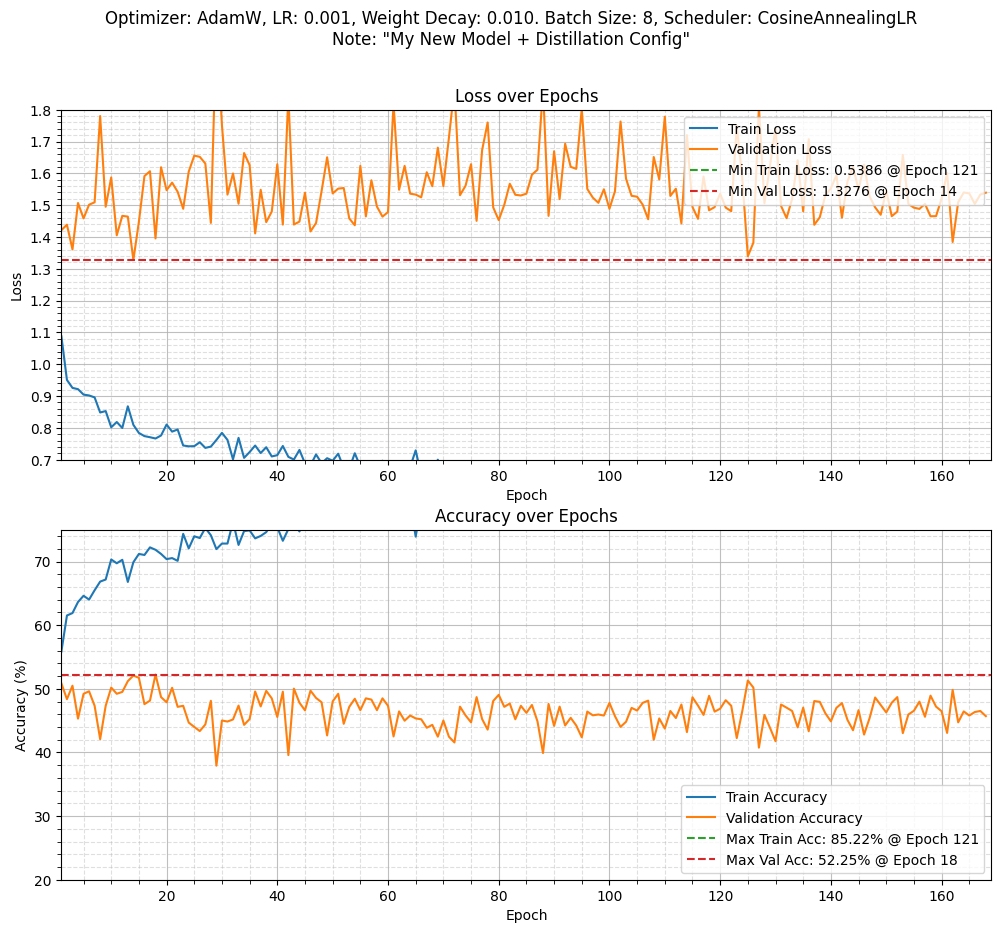

In [25]:
model, best_acc, best_loss, train_losses, train_accs, val_losses, val_accs = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loss_fn=train_loss_fn,  # Distillation loss for training
    val_loss_fn=val_loss_fn,      # Cross-entropy loss for validation
    metric=metric,
    params=params,
    best_test_accuracy=0.0,
    best_val_loss=float('inf'),
    model_name="step1_distillation"
)

# Validate
test_loss, test_acc, test_device_stats = evaluate_epoch(
    model, test_loader, val_loss_fn, metric, best_loss, best_acc
)
print("\n\n")


# Plot training history
optimizer_name = optimizer.__class__.__name__
schdlr = scheduler.__class__.__name__ if scheduler is not None else "None"
wd = optimizer.param_groups[0]['weight_decay']
NOTE = "My New Model + Distillation Config"
plot_training_history(
    train_losses, train_accs, val_losses, val_accs,
    details=f"Optimizer: {optimizer_name}, LR: {params['learning_rate']}, Weight Decay: {wd:1.3f}. "
            f"Batch Size: {params['batch_size']}, Scheduler: {schdlr}\nNote: \"{NOTE}\"")